## Libs

In [1]:
import os
import threading
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.tensorboard as tb
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (18,2.5)

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/kichanglee/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/

## Global Params

In [2]:
BATCH_SIZE     = 256
INPUT_SIZE     = 50
NUM_LAYERS     = 1
LSTM_HS        = 512
NUM_DIRECTION  = 2

L2WEIGHT_DECAY = 0.000001
LEARNING_RATE  = 0.0001
EPOCHS         = 600

GPU_NUM        = 0
MultiGPU       = False
TRAIN_DATA_DIR = './PhysioNet_CEBS_TrainDataset/'
TEST_DATA_DIR  = './PhysioNet_CEBS_TestDataset/'

ModelName     = 'HeartQuake_Baseline'
TB_writer     = tb.SummaryWriter('./Tensorboard/' + ModelName)
ModelSavePath = './Saved_Model/' + ModelName + '/' 
if not os.path.isdir(ModelSavePath):
    os.makedirs(ModelSavePath)
    
IS_CUDA = torch.cuda.is_available()
DEVICE  = torch.device('cuda:' + str(GPU_NUM) if IS_CUDA else 'cpu')

## Dataset Parser

In [3]:
class SensorDataset(Dataset):
    def __init__(self, x_scg, y_ecg, window_stride, window_size):
        self.x_scg = x_scg
        self.y_ecg = y_ecg
        self.window_size   = window_size
        self.window_stride = window_stride
        self.cnt = 0
        
    def __len__(self):
        self.len = len(self.x_scg) - ((self.cnt * self.window_stride) + self.window_size)
        return self.len

    def __getitem__(self, index):
        if len(self.x_scg) < (self.cnt * self.window_stride) + self.window_size:
            self.cnt = 0
        x_scg = self.x_scg[(self.cnt * self.window_stride) : (self.cnt * self.window_stride) + self.window_size]
        y_ecg = self.y_ecg[(self.cnt * self.window_stride) : (self.cnt * self.window_stride) + self.window_size]
        x_scg = torch.tensor(x_scg, dtype=torch.float)
        y_ecg = torch.tensor(y_ecg, dtype=torch.float)
        self.cnt += 1
        return x_scg, y_ecg

In [4]:
class DATASET_LOADER:
    def __init__(self, train_dir, test_dir, batch_size, preloader_gpu_mem, num_worker_loader):
        self.train_dir  = train_dir
        self.test_dir   = test_dir
        self.batch_size = batch_size
        self.preloader  = preloader_gpu_mem
        self.num_worker = num_worker_loader
        
    def train_loader(self):
        '''''''''''''''''''''''''''''''''
        Load training dataset
        '''''''''''''''''''''''''''''''''
        print("Start to load training dataset...")
        DATA_DIR  = self.train_dir
        DATA_LIST = os.listdir(DATA_DIR)
        DATA_LIST.sort()

        ECG_LIST, SCG_LIST = [], []
        for FILE_NAME in DATA_LIST:
            if 'ECG' in FILE_NAME:
                ECG_LIST.append(FILE_NAME)
            else:
                SCG_LIST.append(FILE_NAME)
        ECG_LIST.sort(); SCG_LIST.sort();

        Y_TRAIN_ECG = np.array([])
        X_TRAIN_SCG = np.array([])
        for file_idx in range(0,len(ECG_LIST)):
            ecg_data = pd.read_csv(DATA_DIR + ECG_LIST[file_idx], header=None).to_numpy()
            ecg_data = np.reshape(ecg_data, -1)
            Y_TRAIN_ECG = np.append(Y_TRAIN_ECG, ecg_data)

            scg_data = pd.read_csv(DATA_DIR + SCG_LIST[file_idx], header=None).to_numpy()
            scg_data = np.reshape(scg_data, -1)
            X_TRAIN_SCG = np.append(X_TRAIN_SCG, scg_data)

        Y_TRAIN_ECG = np.reshape(Y_TRAIN_ECG, (-1, 1))
        X_TRAIN_SCG = np.reshape(X_TRAIN_SCG, (-1, 1))

        print('LOADDED ECG Training: ', np.shape(Y_TRAIN_ECG))
        print('LOADDED SCG Training: ', np.shape(X_TRAIN_SCG))
    
        TRAIN_DATASET     = SensorDataset(X_TRAIN_SCG, Y_TRAIN_ECG, 125, 750)
        TRAIN_DATA_LOADER = DataLoader(TRAIN_DATASET, num_workers=self.num_worker, batch_size=self.batch_size, 
                                       shuffle=True, pin_memory=self.preloader, drop_last=True)
        
        return TRAIN_DATA_LOADER
    
    def test_loader(self):
        '''''''''''''''''''''''''''''''''
        Load test dataset
        '''''''''''''''''''''''''''''''''
        print("Start to load test dataset...")
        DATA_DIR  = self.test_dir
        DATA_LIST = os.listdir(DATA_DIR)
        DATA_LIST.sort()

        ECG_LIST, SCG_LIST = [], []
        for FILE_NAME in DATA_LIST:
            if 'ECG' in FILE_NAME:
                ECG_LIST.append(FILE_NAME)
            else:
                SCG_LIST.append(FILE_NAME)
        ECG_LIST.sort()
        SCG_LIST.sort()

        print(ECG_LIST)
        print(SCG_LIST)
        Y_TEST_ECG = np.array([])
        X_TEST_SCG = np.array([])
        for file_idx in range(0, len(ECG_LIST)):
            ecg_data = pd.read_csv(DATA_DIR + ECG_LIST[file_idx], header=None).to_numpy()
            ecg_data = np.reshape(ecg_data, -1)
            for idx in range(0, 5):
                Y_TEST_ECG = np.append(Y_TEST_ECG, ecg_data)

            scg_data = pd.read_csv(DATA_DIR + SCG_LIST[file_idx], header=None).to_numpy()
            scg_data = np.reshape(scg_data, -1)
            for idx in range(0, 5):
                X_TEST_SCG = np.append(X_TEST_SCG, scg_data)

        Y_TEST_ECG = np.reshape(Y_TEST_ECG, (-1, 1))
        X_TEST_SCG = np.reshape(X_TEST_SCG, (-1, 1))

        global Test_sample
        Test_sample = X_TEST_SCG[:750*BATCH_SIZE]
        Test_sample = np.reshape(Test_sample, (1, -1))
        Test_sample = torch.tensor(Test_sample, dtype=torch.float)
        Test_sample = Test_sample.to(DEVICE)

        plt.title('---- Sample ECG and SCG ----')
        plt.plot(Y_TEST_ECG[:750])
        plt.show()
        plt.plot(X_TEST_SCG[:750])
        plt.show()
        print('TEST smaple size: ', np.shape(Test_sample))
        print('LOADDED ECG Test: ', np.shape(Y_TEST_ECG))
        print('LOADDED SCG Test: ', np.shape(X_TEST_SCG))

        TEST_DATASET     = SensorDataset(X_TEST_SCG, Y_TEST_ECG, 250, 750)
        TEST_DATA_LOADER = DataLoader(TEST_DATASET, num_workers=self.num_worker, batch_size=self.batch_size, 
                                      shuffle=False, pin_memory=self.preloader, drop_last=True)
        
        return TEST_DATA_LOADER

## Model

In [5]:
class Stacked_BiLSTM(nn.Module):
    def __init__(self, batch_size, input_size, num_layers, hidden_size, num_direction):
        super().__init__()
        self.input_size  = input_size
        self.batch_size  = batch_size
        self.num_layers  = num_layers
        self.hidden_size = hidden_size
        self.num_direction = num_direction
        
        self.bilstm1 = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size,
                               num_layers=self.num_layers, bidirectional=True, batch_first=True)
        self.bilstm2 = nn.LSTM(input_size=self.hidden_size*self.num_direction, hidden_size=self.hidden_size,
                               num_layers=self.num_layers, bidirectional=True, batch_first=True)
        
        self.fc1 = nn.Linear(self.hidden_size*self.num_direction*(750//self.input_size), self.hidden_size*2)
        self.fc2 = nn.Linear(self.hidden_size*2, self.hidden_size//2)
        self.fc3 = nn.Linear(self.hidden_size//2, 750)
        
    def init_hidden(self, num_layers, num_direction, batch_size, hidden_size):
        hidden_state = torch.zeros(num_layers*num_direction, batch_size, hidden_size).to(DEVICE)
        cell_state   = torch.zeros(num_layers*num_direction, batch_size, hidden_size).to(DEVICE)
        return hidden_state, cell_state
        
    def forward(self, x):
        hs_1, cs_1 = self.init_hidden(self.num_layers, self.num_direction, self.batch_size, self.hidden_size)
        x         = x.view(self.batch_size, -1, self.input_size)
        x_bilstm1, (output_hs, output_cs) = self.bilstm1(x, (hs_1, cs_1))
        x_bilstm2, (output_hs, output_cs) = self.bilstm2(x_bilstm1, (output_hs, output_cs))
        x_fc1 = self.fc1(x_bilstm2.contiguous().view(self.batch_size, -1))
        x_fc2 = self.fc2(x_fc1)
        x_fc3 = self.fc3(x_fc2)
        
        return x_fc3

## Main

Start to load training dataset...
LOADDED ECG Training:  (2579000, 1)
LOADDED SCG Training:  (2579000, 1)
Start to load test dataset...
['b001_ECG.csv']
['b001_SCG.csv']


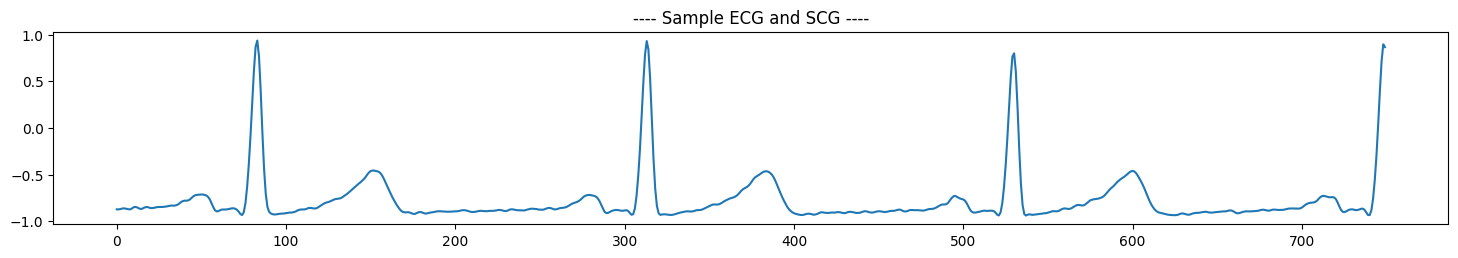

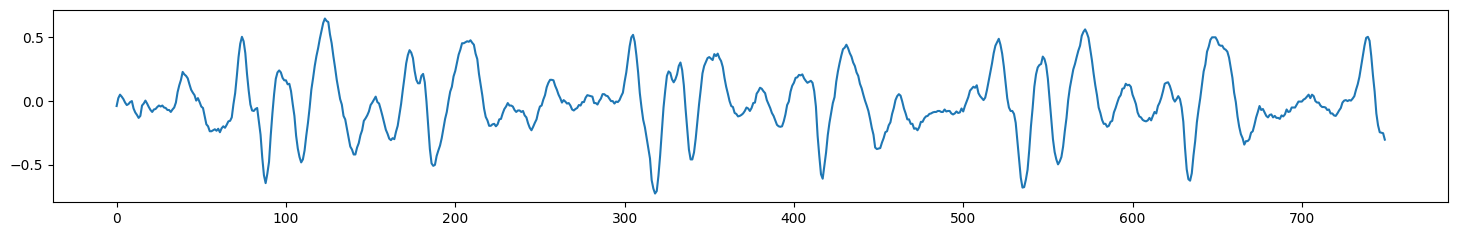

TEST smaple size:  torch.Size([1, 192000])
LOADDED ECG Test:  (290015, 1)
LOADDED SCG Test:  (290015, 1)


EPOCH:   0%|          | 0/600 [00:00<?, ?it/s]


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/kichanglee/Library/Python/3.9/lib/python/site-packages/torch/__init__.py"

In [6]:
if __name__ == '__main__':
    DL = DATASET_LOADER(TRAIN_DATA_DIR, TEST_DATA_DIR, BATCH_SIZE, True, 2)
    TRAIN_LOADER = DL.train_loader()
    TEST_LOADER  = DL.test_loader()
    
    BATCH_SIZE = int(BATCH_SIZE / 4) if MultiGPU else BATCH_SIZE
    
    #MODEL_LOAD_PATH = './saved_model_phase2/HeartQuake_base_50_transfer_2/HeartQuake_base_50_transfer_2_475.pth'
    
    MODEL = Stacked_BiLSTM(BATCH_SIZE, INPUT_SIZE, NUM_LAYERS, LSTM_HS, NUM_DIRECTION)
    #MODEL.load_state_dict(torch.load(MODEL_LOAD_PATH))
    MODEL.to(DEVICE)
    
    CRITERIAN = nn.MSELoss().to(DEVICE)
    OPTIMIZER = optim.Adam(MODEL.parameters(), lr = LEARNING_RATE, weight_decay = L2WEIGHT_DECAY)
    SCHEDULER = optim.lr_scheduler.StepLR(OPTIMIZER, step_size=3, gamma=0.5)
    
    GLOBAL_STEP  = 0
    LOSS_TRACE   = []
    for epoch in tqdm(range(EPOCHS), desc='EPOCH'):
        LOSS_TRACE   = []
        
        for idx, batch in tqdm(enumerate(TRAIN_LOADER), desc='TRAINING', total=len(TRAIN_LOADER)):
            MODEL.train()
            
            X_train, Y_train = batch
            X_train, Y_train = X_train.to(DEVICE), Y_train.to(DEVICE)
            
            Y_pred  = MODEL(X_train)
            Y_train = Y_train.squeeze(2)
            LOSS    = CRITERIAN(Y_pred, Y_train)
            LOSS_TRACE.append(LOSS.cpu().detach().numpy())
            
            OPTIMIZER.zero_grad()
            LOSS.backward()
            OPTIMIZER.step()
            
            TB_writer.add_scalar('Loss', LOSS, GLOBAL_STEP)
            GLOBAL_STEP += 1
        
        LOSS_TRACE_FOR_TEST = []
        for idx, batch in tqdm(enumerate(TEST_LOADER), desc='TEST', total=len(TEST_LOADER)):
            X_test, Y_test = batch
            X_test, Y_test = X_test.to(DEVICE), Y_test.to(DEVICE)

            with torch.no_grad():
                MODEL.eval()
                Y_pred_test = MODEL(X_test)
                Y_test      = Y_test.squeeze(2)
                LOSS_test   = CRITERIAN(Y_pred_test, Y_test)
                LOSS_TRACE_FOR_TEST.append(LOSS_test.cpu().detach().numpy())

                if idx == 0:
                    Predicted_ecg   = Y_pred_test.squeeze().cpu().detach()
                    Predicted_ecg   = Predicted_ecg.view(-1, 750)
                    plt.plot(Predicted_ecg[0])
                    plt.show()

        print('(epoch %i/200) Training Loss: %f' % (epoch + 1, np.average(LOSS_TRACE)))
        print('(epoch %i/200) Test Loss    : %f' % (epoch + 1, np.average(LOSS_TRACE_FOR_TEST)))
            
        if (epoch + 1) % 5 == 0:
            torch.save(MODEL.state_dict(), ModelSavePath + ModelName + '_' + str(epoch+1) + '.pth')
            
    torch.save(MODEL.state_dict(), ModelSavePath + ModelName + '_Last.pth')